# Prepare datasets to train the surrogate model

## Imports

In [1]:
import json
import random

import mat73
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import iplantuml
from parameters import *

## Seed

In [2]:
np.random.seed(seed)
random.seed(seed)

## Import matlab .mat files

In [3]:
def load_matlab_mat(file: Path,
                    dtype: np.dtype = np.float32,
                    res_type: str = 'phavg') -> pd.DataFrame:
    # Load MATLAB .mat file
    mat_data = scipy.io.loadmat(file)

    # Extract structured array from the loaded .mat file
    res_type = mat_data[res_type]

    # Iterate over each field and convert it to the new dtype
    fields = sorted(set(res_type.dtype.names) - {'res_range', 'N'})
    df = pd.DataFrame(columns=fields)
    for i, field_name in enumerate(fields):
        if field_name in ('res_range', 'N'):
            continue
        df[field_name] = res_type[field_name].item().reshape(-1).astype(dtype)
    return df


df = load_matlab_mat(matlab_directory / 'case 1/ms008mpt001.mat', res_type='res')
df

,Cm,Cmx,Cmy,Cp,Cr,Ct,Cthrust,Ctot,Fr,Ft,...,alpha_eff,ddpitch,dpitch,phase,phase_cont,pitch,t,t_T,tc,tc_Ueff
0,-0.066091,0.084335,-0.070828,0.372000,0.633340,0.551177,-0.551177,0.839592,1.988318,1.730374,...,-0.000968,2.244266,0.013838,0.0,0.0,-0.000017,-9.049000,-8.019508,-125.970139,0.023201
1,-0.062456,0.072638,-0.061979,0.369127,0.626482,0.546925,-0.546925,0.831629,1.966789,1.717025,...,-0.000472,1.685023,0.015620,0.0,0.0,-0.000008,-9.048000,-8.018622,-125.956223,0.046403
2,-0.058808,0.060773,-0.053502,0.366297,0.619448,0.542735,-0.542735,0.823576,1.944706,1.703872,...,0.000143,1.091636,0.017162,0.0,0.0,0.000003,-9.047000,-8.017735,-125.942299,0.069604
3,-0.055151,0.049006,-0.045439,0.363530,0.612339,0.538636,-0.538636,0.815529,1.922387,1.691003,...,0.000879,0.465185,0.018385,0.0,0.0,0.000015,-9.046000,-8.016850,-125.928383,0.092806
4,-0.051480,0.037593,-0.037833,0.360845,0.605245,0.534656,-0.534656,0.807576,1.900118,1.678507,...,0.001731,-0.192579,0.019202,0.0,0.0,0.000030,-9.045000,-8.015964,-125.914459,0.116007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50995,0.019699,0.019671,-0.089344,0.373340,0.366720,0.553096,-0.553096,0.663626,1.151287,1.736399,...,-0.000000,0.000000,0.000000,0.0,0.0,-0.000000,41.945999,37.173862,583.925720,831.745728
50996,0.019226,0.019530,-0.091652,0.373332,0.364256,0.553084,-0.553084,0.662257,1.143550,1.736362,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,41.946999,37.174751,583.939636,831.768982
50997,0.018778,0.019399,-0.094077,0.373388,0.362001,0.553168,-0.553168,0.661090,1.136473,1.736625,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,41.948002,37.175636,583.953552,831.792175
50998,0.018366,0.019272,-0.096509,0.373495,0.359991,0.553325,-0.553325,0.660123,1.130163,1.737119,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,41.949001,37.176521,583.967468,831.815369


## Convert matlab .mat files to pandas dataframes

In [4]:
def interpolate(df, n):
    new_df = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        new_df[col] = np.interp(np.linspace(0, 1, n), np.linspace(0, 1, len(df)), df[col])
    return new_df


def convert_case_3_mat2df(df_dir: Path, mat_file):
    data = None
    for dataset_type in dataset_types:
        (df_dir / dataset_type).mkdir(parents=True, exist_ok=True)
        full_df_file = df_dir / dataset_type / f'{mat_file.stem}_full.pkl'
        if full_df_file.exists():
            df = pd.read_pickle(full_df_file)
        else:
            # load data only once
            if data is None:
                data = mat73.loadmat(mat_file)
            df = pd.DataFrame(data[dataset_type])
            df.to_pickle(full_df_file)
        # convert dataframe of lists (each row is a list / experiment) into list of dataframes (each dataframe is an experiment)
        for i in range(len(df)):
            df_file = df_dir / dataset_type / f'{mat_file.stem}_{i}.pkl'
            if df_file.exists():
                continue
            df_row = df.iloc[i]
            columns = df_row.index
            df2 = pd.DataFrame(columns=columns)
            for col_name in columns:
                # check if col_name is a string
                df2[col_name] = df_row[col_name]
            # slice res
            if dataset_type == 'res':
                # slice df to avoid variable yaw rotation speed
                phase = np.array(df2['phase'])
                d_phase = phase[1:] - phase[:-1]
                falling_edges = np.where(d_phase < 0)[0]
                df2 = df2[falling_edges[5]: falling_edges[10]]
                df2 = interpolate(df2, turn_length * 5)
            else:
                df2 = interpolate(df2, turn_length)
            df2['pitch'] = np.deg2rad(df2['pitch'])
            df2['dpitch'] = np.deg2rad(df2['dpitch'])
            df2.to_pickle(df_file)

In [5]:
def convert_case_mat2df(matlab_dir: Path, df_dir: Path, dtype: np.dtype = np.float32):
    # Load all .mat files
    mat_files = list(matlab_dir.glob('*.mat'))
    for mat_file in mat_files:
        try:
            if len(mat_files) == 1: raise NotImplementedError  # mat73
            for dataset_type in dataset_types:
                (df_dir / dataset_type).mkdir(parents=True, exist_ok=True)
                df_file = df_dir / dataset_type / f'{mat_file.stem}.pkl'
                if df_file.exists():
                    continue
                df = load_matlab_mat(mat_file, dtype=dtype, res_type=dataset_type)
                if dataset_type == 'res':
                    # slice df to avoid variable yaw rotation speed
                    df = df[(df['phase_cont'] <= 360 * 10) & (df['phase_cont'] >= 360 * 5)]
                    df = interpolate(df, turn_length * 5)
                else:
                    df = interpolate(df, turn_length)
                df.to_pickle(df_file)
        except NotImplementedError:  # mat73
            convert_case_3_mat2df(df_dir, mat_file)

In [6]:
for matlab_dir, case_dir in zip(matlab_cases_dir, dataset_cases_dir):
    df_dir = case_dir / 'dataframes'
    df_dir.mkdir(parents=True, exist_ok=True)
    convert_case_mat2df(matlab_dir, df_dir)

In [7]:
df = pd.read_pickle(dataset_directory / 'case 3/dataframes/res/vawt_data_0.pkl')
df

,Cm,Cp,Cr,Ct,Cthrust,alpha,ddpitch,dpitch,phase,pitch,t,t_T
0,-0.115565,-0.039625,0.419017,-0.058703,0.057646,-8.251739,753.761933,0.657829,359.855424,-0.143011,1.128000,0.999669
1,-0.141619,0.012669,0.974072,0.018769,0.101528,-4.323456,638.453133,0.934055,7.083322,-0.124894,1.150651,1.019743
2,-0.173101,-0.060372,1.565866,-0.089440,0.473751,-0.074442,492.892821,1.158634,14.311220,-0.101085,1.173301,1.039816
3,-0.150843,-0.004946,1.991430,-0.007328,0.737948,4.415114,320.466805,1.320236,21.539117,-0.072882,1.195952,1.059890
4,-0.182728,0.115537,2.442133,0.171166,1.025255,9.050948,126.077964,1.409111,28.767015,-0.041826,1.218602,1.079964
...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.261143,-0.163964,-1.830371,-0.242909,1.107851,-19.789427,863.190468,-0.712528,330.690393,-0.141869,6.677398,5.917720
246,0.216844,-0.258644,-1.433083,-0.383176,0.893812,-17.634445,893.809336,-0.363889,337.918291,-0.154084,6.700048,5.937793
247,0.163612,-0.325003,-0.848949,-0.481486,0.683058,-15.004689,884.827369,-0.011046,345.146188,-0.158322,6.722699,5.957867
248,0.025455,-0.164063,-0.157663,-0.243056,0.261863,-11.911006,838.551502,0.330799,352.374086,-0.154666,6.745349,5.977941


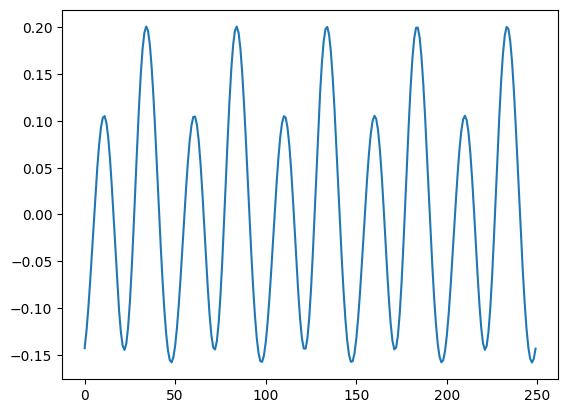

In [8]:
plt.plot(df['pitch'])

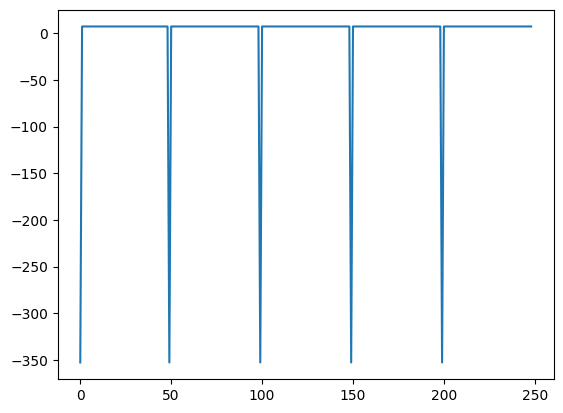

In [9]:
phase = np.array(df['phase'])
dphase = phase[1:] - phase[:-1]
plt.plot(dphase)

# Compute omega (rad/step) from phase (deg)

In [10]:
phase = np.array(df['phase'])
omega = phase[2] - phase[1]
(omega := np.deg2rad(omega))

0.12615061515438047

## Define the models

### Agent : State, action, reward

In [11]:
# @formatter:off

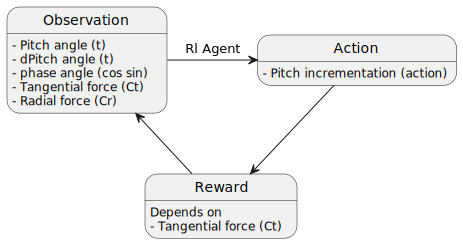

In [12]:
%%plantuml

@startuml

state Observation
Observation: - Pitch angle (t)
Observation: - dPitch angle (t)
Observation: - phase angle (cos sin)
Observation: - Tangential force (Ct)
Observation: - Radial force (Cr)

Observation -right-> Action : Rl Agent
Action: - Pitch incrementation (action)
Action --> Reward
Reward --> Observation
Reward: Depends on
Reward: - Tangential force (Ct)  


@enduml

## Surrogate model
### Inputs
The surrogate model takes as input the state and the action. Respectively :
- State
    - `x_Pitch[i]` = `data_frame[Pitch][i]`
    - `x_dPitch[i]` = `data_frame[Pitch][i] - data_frame[Pitch][i - 1]`
    - `x_cos_phase[i]` = `data_frame[cos_phase][i]`
    - `x_sin_phase[i]` = `data_frame[sin_phase][i]`
    - `x_Ct[i]` = `data_frame[Ct][i]`
    - `x_Cr[i]` = `data_frame[Cr][i]`
    - `x_Cm[i]` = `data_frame[Cm][i]`
- Action
    - `x_action[i]` = `data_frame[Pitch][i + 1] - data_frame[Pitch][i]` : pitch incrementation
### Outputs
The surrogate model produces every forces needed to deduce others and pursue the simulation and the training of the RL agent. Respectively :
- `y_ct[i]` = `data_frame[Ct][i+1]`
- `y_cr[i]` = `data_frame[Cr][i+1]`

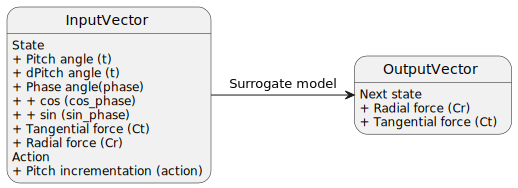

In [13]:
%%plantuml
@startuml


state InputVector
InputVector: State
InputVector: + Pitch angle (t)
InputVector: + dPitch angle (t)
InputVector: + Phase angle(phase)
InputVector: +  + cos (cos_phase)
InputVector: +  + sin (sin_phase)
InputVector: + Tangential force (Ct)
InputVector: + Radial force (Cr)
InputVector: Action
InputVector: + Pitch incrementation (action)
InputVector -right-> OutputVector: Surrogate model
OutputVector: Next state
OutputVector: + Radial force (Cr)
OutputVector: + Tangential force (Ct)

@enduml

In [14]:
# formatter:on

### Convert dataframe to data and labels

In [15]:

def convert_dataframe(dataframe):
    """
    Convert a dataframe to train and test datasets
    :param dataframe: the dataframe to convert
    :param train_ratio: the ratio of the train dataset
    :return: the train and test datasets
    """
    x = pd.DataFrame(columns=x_columns)
    y = pd.DataFrame(columns=y_columns)
    
    #x_columns = 'cos_phase', 'sin_phase', 'Ct', 'Cr', 'pitch', 'dpitch', 'action'
    # y_columns = 'Ct', 'Cr'

    phase = np.array(dataframe['phase'][1:-1])
    x['cos_phase'] = np.cos(np.deg2rad(phase))
    x['sin_phase'] = np.sin(np.deg2rad(phase))
    
    x['Ct'] = np.array(dataframe['Ct'][1:-1])
    x['Cr'] = np.array(dataframe['Cr'][1:-1])
    x['pitch'] = np.array(dataframe['pitch'][1:-1])
    x['dpitch'] = np.array(dataframe['pitch'][1:-1]) - np.array(dataframe['pitch'][:-2])
    x['action'] = np.array(dataframe['pitch'][2:]) - np.array(dataframe['pitch'][1:-1])

    y['Ct'] = np.array(dataframe['Ct'][2:])
    y['Cr'] = np.array(dataframe['Cr'][2:])
    return x, y

dataframe = pd.read_pickle(dataset_directory / 'case 3/dataframes/res/vawt_data_0.pkl')
x, y = convert_dataframe(dataframe)

In [16]:
x

,cos_phase,sin_phase,Ct,Cr,pitch,dpitch,action
0,0.992368,0.123313,0.018769,0.974072,-0.124894,0.018116,0.023809
1,0.968967,0.247189,-0.089440,1.565866,-0.101085,0.023809,0.028203
2,0.930167,0.367136,-0.007328,1.991430,-0.072882,0.028203,0.031057
3,0.876584,0.481249,0.171166,2.442133,-0.041826,0.031057,0.032174
4,0.809069,0.587713,0.169360,2.961895,-0.009652,0.032174,0.031425
...,...,...,...,...,...,...,...
243,0.803467,-0.595349,-0.272294,-2.283347,-0.121957,-0.026963,-0.019912
244,0.871987,-0.489529,-0.242909,-1.830371,-0.141869,-0.019912,-0.012215
245,0.926649,-0.375928,-0.383176,-1.433083,-0.154084,-0.012215,-0.004238
246,0.966583,-0.256354,-0.481486,-0.848949,-0.158322,-0.004238,0.003656


In [17]:
y

,Ct,Cr
0,-0.089440,1.565866
1,-0.007328,1.991430
2,0.171166,2.442133
3,0.169360,2.961895
4,0.065183,3.497549
...,...,...
243,-0.242909,-1.830371
244,-0.383176,-1.433083
245,-0.481486,-0.848949
246,-0.243056,-0.157663


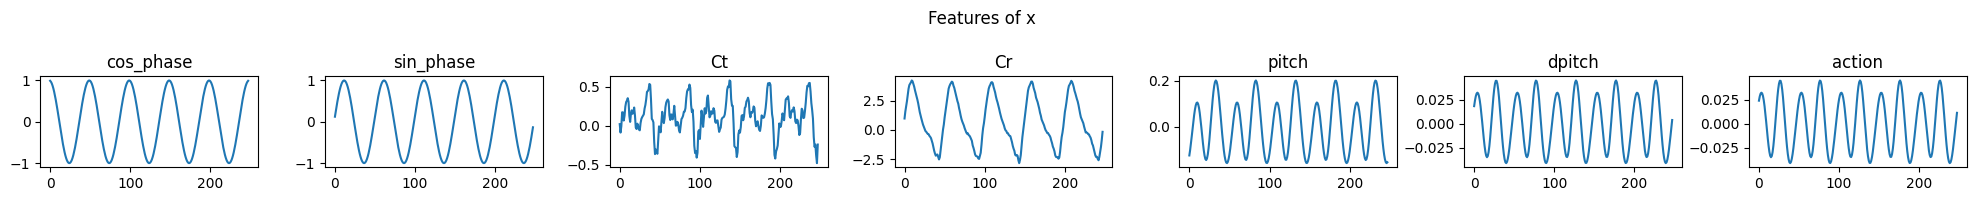

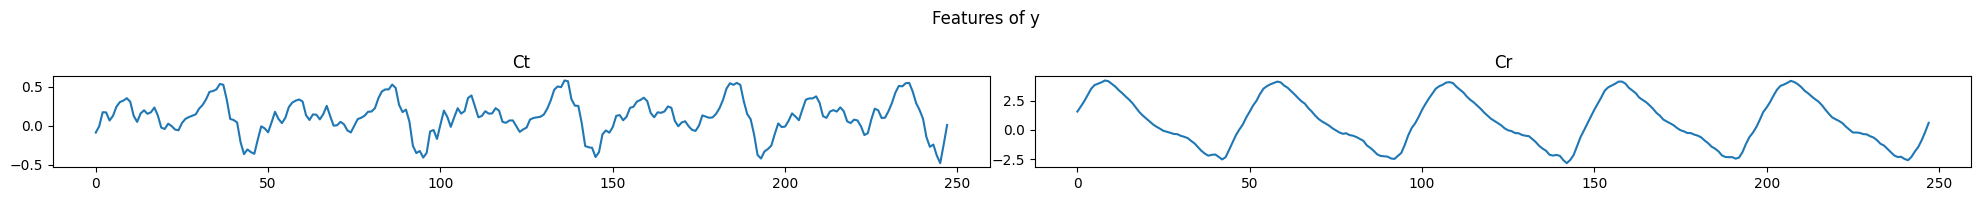

In [18]:
n = 200000
# plot features of x
fig, axs = plt.subplots(1, len(x_columns), figsize=(20, 2))
for i, col in enumerate(x_columns):
    axs[i].plot(x[col][:n])
    axs[i].set_title(col)
fig.suptitle('Features of x')
plt.tight_layout()
plt.show()
# plot features of y
fig, axs = plt.subplots(1, len(y_columns), figsize=(20, 2))
for i, col in enumerate(y_columns):
    axs[i].plot(y[col][:n])
    axs[i].set_title(col)
fig.suptitle('Features of y')
plt.tight_layout()
plt.show()

### Convert full cases to correct data format for the surrogate model

In [19]:
def convert_case_df2arrays(dataframe_case_dir:Path, case:str):
    """
    Convert a case dataframe to train and test arrays
    :param case: the case to convert
    :return: the train and test arrays
    """
    X, Y = [], []

    dataframe_files = [f for f in dataframe_case_dir.glob(f'*.pkl') if 'full' not in f.stem]
    dataframe_files = np.array(dataframe_files, dtype=str)

    # selection of datas :
    # case 1 : first 30 cases + 30 random U (30, ...)
    if case  == 'case 1' :
        random_elements = np.random.randint(30, dataframe_files.shape[0], 30)
        dataframe_files = np.concatenate((dataframe_files[:30], dataframe_files[random_elements]))

    # case 2 : first 30 cases + 40 random U (30, ...)
    elif case == 'case 2' :
        random_elements = np.random.randint(30, dataframe_files.shape[0], 40)
        dataframe_files = np.concatenate((dataframe_files[:30], dataframe_files[random_elements]))

    # case 3 : linear probability to be kept from 1 to 0
    elif case == 'case 3' :
        probabilities = np.linspace(1, 0, dataframe_files.shape[0])
        kept_elements = np.random.random(dataframe_files.shape[0]) < probabilities
        dataframe_files = dataframe_files[kept_elements]


    for file in dataframe_files:
        dataframe = pd.read_pickle(file)
        x, y = convert_dataframe(dataframe)
        x_array = x.to_numpy(dtype=np.float32)
        y_array = y.to_numpy(dtype=np.float32)
        X.append(x_array)
        Y.append(y_array)
    X = np.concatenate(X)
    Y = np.concatenate(Y)
    return X, Y

In [20]:
for case_dir in dataset_cases_dir:
    for dataset_type in dataset_types :
        df_dir = case_dir / 'dataframes' / dataset_type
        array_case_dir = case_dir / 'array' / dataset_type
        array_case_dir.mkdir(parents=True, exist_ok=True)
        X, Y = convert_case_df2arrays(df_dir, case_dir.stem)
        # normalize the datas
        X_mean, X_std = X.mean(axis=0), X.std(axis=0)
        Y_mean, Y_std = Y.mean(axis=0),  Y.std(axis=0)
        ## add epsilon to avoid division by 0
        epsilon = 1e-6
        X_std[X_std < epsilon] = epsilon
        Y_std[Y_std < epsilon] = epsilon

        X = (X - X_mean) / X_std
        Y = (Y - Y_mean) / Y_std

        # shuffle the datas
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X[indices]
        Y = Y[indices]

        # save normalization parameters
        json.dump({
            'X mean': X_mean.tolist(),
            'X std': X_std.tolist(),
            'Y mean': Y_mean.tolist(),
            'Y std': Y_std.tolist()
        }, open(array_case_dir / 'norm.json', 'w'))

        # save the datas
        np.save(array_case_dir / 'X.npy', X)
        np.save(array_case_dir / 'Y.npy', Y)

## Mix datasets together

In [21]:
for dataset_type in dataset_types:
    Xs, Ys = [], []
    for case_dir in dataset_cases_dir:
        array_case_dir = case_dir / 'array' / dataset_type
        X = np.load(array_case_dir / 'X.npy')
        Y = np.load(array_case_dir / 'Y.npy')
        # denormalize the datas
        norm = json.load(open(array_case_dir / 'norm.json'))
        X_mean, X_std = np.array(norm['X mean']), np.array(norm['X std'])
        Y_mean, Y_std = np.array(norm['Y mean']), np.array(norm['Y std'])
        X = X * X_std + X_mean
        Y = Y * Y_std + Y_mean

        Xs.append(X)
        Ys.append(Y)


    X = np.concatenate(Xs)
    Y = np.concatenate(Ys)

    indices = np.arange(X.shape[0])

    # shuffle the datas
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]
    # normalize the datas
    X_mean, X_std = X.mean(axis=0), X.std(axis=0)
    Y_mean, Y_std = Y.mean(axis=0), Y.std(axis=0)
    ## add epsilon to avoid division by 0
    epsilon = 1e-6
    X_std[X_std < epsilon] = epsilon
    Y_std[Y_std < epsilon] = epsilon

    X = (X - X_mean) / X_std
    Y = (Y - Y_mean) / Y_std

    dataset_dir = output_directory / 'dataset' / 'full' / 'array' / dataset_type
    dataset_dir.mkdir(parents=True, exist_ok=True)
    # save the datas
    np.save(dataset_dir / 'X.npy', X)
    np.save(dataset_dir / 'Y.npy', Y)
    # save normalization parameters
    json.dump({
        'X mean': X_mean.tolist(),
        'X std': X_std.tolist(),
        'Y mean': Y_mean.tolist(),
        'Y std': Y_std.tolist()
    }, open(dataset_dir / 'norm.json', 'w'))